# The Infographics Show Analysis

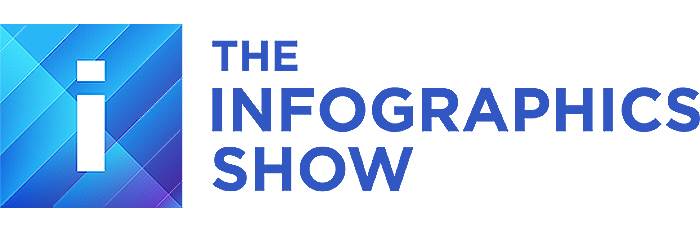

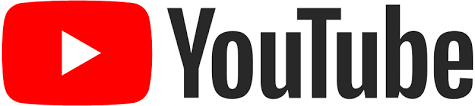


In this project, I will be analyzing YouTube statistics from The Infographics Show, one of the most popular channels for animated motion videos on fun facts and hypothetical scenarios. As of 2023, The Infographics Show has over 4.2 thousand videos and posts new content every week, making the channel a great option for practicing data science skills and predictive modeling on real world data. My objective is to find features in You Tube data that allow me to predict the number of views an Infographics Show video will receive.

The following data has been pulled from the YouTube API. As YouTube data is constantly updated and thus considered real time data, it is important that we pull and perform analysis on data that is up to date. Moreover, we will be storing the cleaned version of the data into an Amazon Web Services (AWS) Postgres Database so that we not only preserve the cleaned version of the data but also are able to address scalability concerns with real-time data.


In [ ]:
!pip3 install --upgrade google-api-python-client

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 23.6 MB/s eta 0:00:00
  Attempting uninstall: google-api-python-client
    Found existing installation: google-api-python-client 2.84.0
    Uninstalling google-api-python-client-2.84.0:
      Successfully uninstalled google-api-python-client-2.84.0


We begin with the necessary imports.

In [1]:
from googleapiclient.discovery import build
import pandas as pd
import seaborn as sns
import numpy as np
import re
import json
from matplotlib import pyplot as plt

The API key used here is confidential and used to access data from the YouTube API.

In [2]:
#Key
API_KEY = "{{API KEY}}"

In [3]:
api_service_name = "youtube"
api_version = "v3"


# Get credentials and create an API client
youtube = build(api_service_name, api_version, developerKey=API_KEY)

Since we are interested in The Infographics Show, we retrieve channel's ID from the page source on the channel's YouTube homepage. The ID turns out to be the string in the channel_ids list.

In [4]:
channel_ids = ["UCfdNM3NAhaBOXCafH7krzrA"]

def get_channel_stats(youtube, channel_ids):

    all_data = []
    request = youtube.channels().list(
        part="snippet,contentDetails,statistics",
        id= ",".join(channel_ids)
    )
    response = request.execute()

    #loop through items
    for item in response['items']:
        data = {
            'channelName': item['snippet']['title'],
            'subscribers': item['statistics']['subscriberCount'],
            'views': item['statistics']['viewCount'],
            'totalViews': item['statistics']['videoCount'],
            'playlistId': item['contentDetails']['relatedPlaylists']['uploads']
        }
        all_data.append(data)

    return pd.DataFrame(all_data)


We can verify that the channel ID corresponds to the correct channel, The Infographics Show.

In [5]:
response = get_channel_stats(youtube, channel_ids)
response

,channelName,subscribers,views,totalViews,playlistId
0,The Infographics Show,13300000,5314649032,4312,UUfdNM3NAhaBOXCafH7krzrA


In [6]:

def get_video_ids(youtube, playlist_id):
    """
      Retrieves the video ID's associated with a given playlist.
    """
    video_ids = []

    request = youtube.playlistItems().list(
        part="snippet, contentDetails",
        playlistId = playlist_id,
        maxResults = 50
    )
    response = request.execute()

    for item in response['items']:
        video_ids.append(item['contentDetails']['videoId'])

    next_page_token = response.get('nextPageToken')
    while next_page_token is not None:
        request = youtube.playlistItems().list(
            part="contentDetails",
            playlistId = playlist_id,
            maxResults = 50,
            pageToken = next_page_token
        )
        response = request.execute()

        for item in response['items']:
            video_ids.append(item["contentDetails"]["videoId"])

        next_page_token = response.get("nextPageToken")


    return video_ids

In [7]:
video_ids = get_video_ids(youtube, "UUfdNM3NAhaBOXCafH7krzrA")

In [8]:
video_ids

['GJ2ctqrUE9E',
 'gOMz813ExoY',
 'DsdD4VL-IRU',
 'dmYrzXPxzyY',
 '2kgmlON3LOk',
 'ZoYeBRb8szw',
 'jz7f-uzKqPQ',
 'jl8lNNXIRs4',
 'Iud5x0PWaYg',
 'InLdcaeozEw',
 'VGQIMQbf8Io',
 'WcxywIF4YUg',
 'A34-nesLjVI',
 'bzU1w4iz1uY',
 'Vsz2E_Yhs34',
 'xwFQfKvKs3w',
 '3x3L8JKSDUs',
 'eds3sdMbPck',
 'HzlBB1dGkGM',
 '5It1H7oXZjE',
 '6ci7rqD5O1o',
 'xffmI3TNrM4',
 'bsKEjhzsomY',
 'i2QTsuFHCc0',
 'EZQ7TDVDqTQ',
 'DRvScF19V60',
 'YHcR68n9gNs',
 'jpZhc6smDLc',
 '9qhbCxXU0jQ',
 'Vt4PdMxrRiY',
 'arojFePYQwI',
 'kZmpYh5Wxto',
 'XPP51PgvGcM',
 'kp409Y51dpg',
 '9vNxv4s4Sps',
 '4eplXybrVO0',
 'kdDpzWW5AlA',
 'apktajqDbq8',
 'vYmgZJG9SdQ',
 'FSaPIkFdHIg',
 'NkUn3EA6z1c',
 'ESBPAFTBvnA',
 '16V_IL517jE',
 'rLt-DvBKEJY',
 'KjrgwjMoWQE',
 'P18XQnqODWA',
 '-pS7m1bZDHU',
 'zshbkU42nWY',
 'H3EaOHLAWmI',
 '5AGsGE_n9s4',
 'k-K-8bmXXWg',
 'g9Dwdt5A_AQ',
 'Tl8iD-hXwoE',
 '4b4B6qrDPdI',
 'q7B1xJn2hKQ',
 'aVmwg9rftCc',
 'mtqLtUQclKM',
 '7Q-kG7SUOGQ',
 '32X-ZEdlCxU',
 '2wyYii0kp_A',
 'vLFXB_STuoQ',
 'nFpczcMx3hw',
 '55c9hP

In [9]:
def get_video_details(youtube, video_ids):

    """
      Retrieves the video details associated with a given list of videos.
    """

    all_video_info = []

    for i in range(0, len(video_ids), 50):
        request = youtube.videos().list(
            part="snippet, contentDetails, statistics",
            id=",".join(video_ids[i:i+50])
        )
        response = request.execute()

        for video in response['items']:
            stats_to_keep = {'snippet': ['channelTitle', 'title', 'description', 'tags', 'publishedAt'],
                            'statistics': ['viewCount', 'likeCount', 'favouriteCount', 'commentCount'],
                            'contentDetails': ['duration', 'definition', 'caption', 'regionRestriction']
                            }
            video_info = {}
            video_info['video_id'] = video['id']

            for k in stats_to_keep.keys():
                for v in stats_to_keep[k]:
                    try:
                        video_info[v] = video[k][v]
                    except:
                        video_info[v] = None

            all_video_info.append(video_info)

    return pd.DataFrame(all_video_info)

In [10]:
video_df = get_video_details(youtube, video_ids)
video_df[["viewCount"]].sort_values(by="viewCount").head(50)

,viewCount
2745,1000423
1530,10012697
2028,1001898
1006,10026741
3430,1004482
1150,100649
653,1006693
4285,1007116
1143,1007385
270,1007444


In [11]:
video_df.head(20)

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption,regionRestriction
0,GJ2ctqrUE9E,The Infographics Show,Is Ukraine About to Take Back Bakhmut?,,None,2023-08-07T14:00:20Z,13917,1465,None,48,PT59S,hd,false,"{'blocked': ['BY', 'RU']}"
1,gOMz813ExoY,The Infographics Show,What Happened Right After Hiroshima Nuclear Bo...,The US dropped 2 nuclear bombs on Japan to put...,None,2023-08-06T19:15:01Z,274281,5356,None,860,PT26M56S,hd,true,"{'blocked': ['BY', 'RU']}"
2,DsdD4VL-IRU,The Infographics Show,"The Difference Between a Frigate, a Cruiser, a...",,None,2023-08-06T14:00:07Z,41261,2992,None,40,PT1M,hd,false,"{'blocked': ['BY', 'RU']}"
3,dmYrzXPxzyY,The Infographics Show,What if Russia Launched a Nuclear Bomb (Minute...,00:00 What if Russia Launched a Nuclear Bomb (...,None,2023-08-05T19:15:00Z,178032,2909,None,470,PT3H29M45S,hd,false,None
4,2kgmlON3LOk,The Infographics Show,Could You Survive Pararescue Training?,,None,2023-08-05T14:00:03Z,30289,2056,None,38,PT58S,hd,false,"{'blocked': ['BY', 'RU']}"
5,ZoYeBRb8szw,The Infographics Show,Chernobyl Suicide Squad - 3 Men Who Prevented ...,00:00 Chernobyl Suicide Squad - 3 Men Who Prev...,None,2023-08-04T19:15:02Z,49260,1241,None,110,PT4H22M44S,hd,false,None
6,jz7f-uzKqPQ,The Infographics Show,Why Turkey Is Important to NATO,,None,2023-08-04T14:00:38Z,72001,5162,None,238,PT58S,hd,false,"{'blocked': ['BY', 'RU']}"
7,jl8lNNXIRs4,The Infographics Show,50 Insane Facts About Dreams You Never Knew,Can dreams actually kill you? Has anyone ever ...,None,2023-08-03T19:15:03Z,133663,3455,None,342,PT30M4S,hd,true,"{'blocked': ['BY', 'RU']}"
8,Iud5x0PWaYg,The Infographics Show,The Next Global Superpower is Worse Than You C...,,None,2023-08-03T14:00:15Z,91954,5393,None,175,PT56S,hd,false,"{'blocked': ['BY', 'RU']}"
9,InLdcaeozEw,The Infographics Show,Putin Hates Ukraine's New Weapon Supplied by US,Ukraine is going to continue to need help from...,None,2023-08-02T19:15:00Z,515801,12319,None,1485,PT15M29S,hd,true,"{'blocked': ['BY', 'RU']}"


In [12]:
video_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4312 entries, 0 to 4311
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   video_id           4312 non-null   object
 1   channelTitle       4312 non-null   object
 2   title              4312 non-null   object
 3   description        4312 non-null   object
 4   tags               2788 non-null   object
 5   publishedAt        4312 non-null   object
 6   viewCount          4312 non-null   object
 7   likeCount          4312 non-null   object
 8   favouriteCount     0 non-null      object
 9   commentCount       4310 non-null   object
 10  duration           4312 non-null   object
 11  definition         4312 non-null   object
 12  caption            4312 non-null   object
 13  regionRestriction  919 non-null    object
dtypes: object(14)
memory usage: 471.8+ KB


From the information summary on the current data, we see that favouriteCount does not have any useful information; all values are null. Hence, we can drop this column and move on.

In [13]:
video_df.drop(columns=["favouriteCount"], axis=1, inplace=True)

In [15]:
video_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4312 entries, 0 to 4311
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   video_id           4312 non-null   object
 1   channelTitle       4312 non-null   object
 2   title              4312 non-null   object
 3   description        4312 non-null   object
 4   tags               2788 non-null   object
 5   publishedAt        4312 non-null   object
 6   viewCount          4312 non-null   object
 7   likeCount          4312 non-null   object
 8   commentCount       4310 non-null   object
 9   duration           4312 non-null   object
 10  definition         4312 non-null   object
 11  caption            4312 non-null   object
 12  regionRestriction  919 non-null    object
dtypes: object(13)
memory usage: 438.1+ KB


We notice from video_df.info() above that all of the features are of Dtype object. We would like to convert data like viewCount, likeCount, and commentCount into numerical data so that we can perform numerical operations on them (find the median, mean, standard deviation, etc.) easily.

In [16]:
video_df[["viewCount", "likeCount", "commentCount"]] = video_df[["viewCount", "likeCount", "commentCount"]].apply(pd.to_numeric, errors="coerce", axis=1)

In [17]:
video_df[["viewCount", "likeCount", "commentCount"]].head()

,viewCount,likeCount,commentCount
0,13917.0,1465.0,48.0
1,274281.0,5356.0,860.0
2,41261.0,2992.0,40.0
3,178032.0,2909.0,470.0
4,30289.0,2056.0,38.0


In [18]:
video_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4312 entries, 0 to 4311
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   video_id           4312 non-null   object 
 1   channelTitle       4312 non-null   object 
 2   title              4312 non-null   object 
 3   description        4312 non-null   object 
 4   tags               2788 non-null   object 
 5   publishedAt        4312 non-null   object 
 6   viewCount          4312 non-null   float64
 7   likeCount          4312 non-null   float64
 8   commentCount       4310 non-null   float64
 9   duration           4312 non-null   object 
 10  definition         4312 non-null   object 
 11  caption            4312 non-null   object 
 12  regionRestriction  919 non-null    object 
dtypes: float64(3), object(10)
memory usage: 438.1+ KB


   viewCount, likeCount, and commentCount have now been transformed into numerical data. Let's now take a look at some of the other features.
   








   

In [19]:
video_df.head()

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,commentCount,duration,definition,caption,regionRestriction
0,GJ2ctqrUE9E,The Infographics Show,Is Ukraine About to Take Back Bakhmut?,,None,2023-08-07T14:00:20Z,13917.0,1465.0,48.0,PT59S,hd,false,"{'blocked': ['BY', 'RU']}"
1,gOMz813ExoY,The Infographics Show,What Happened Right After Hiroshima Nuclear Bo...,The US dropped 2 nuclear bombs on Japan to put...,None,2023-08-06T19:15:01Z,274281.0,5356.0,860.0,PT26M56S,hd,true,"{'blocked': ['BY', 'RU']}"
2,DsdD4VL-IRU,The Infographics Show,"The Difference Between a Frigate, a Cruiser, a...",,None,2023-08-06T14:00:07Z,41261.0,2992.0,40.0,PT1M,hd,false,"{'blocked': ['BY', 'RU']}"
3,dmYrzXPxzyY,The Infographics Show,What if Russia Launched a Nuclear Bomb (Minute...,00:00 What if Russia Launched a Nuclear Bomb (...,None,2023-08-05T19:15:00Z,178032.0,2909.0,470.0,PT3H29M45S,hd,false,None
4,2kgmlON3LOk,The Infographics Show,Could You Survive Pararescue Training?,,None,2023-08-05T14:00:03Z,30289.0,2056.0,38.0,PT58S,hd,false,"{'blocked': ['BY', 'RU']}"


When we think of a video duration, we think of length of a video as a numeric features. The current format of duration is a string in terms of hours, minutes, and seconds. We would like to use only one unit of metric for time, such as seconds. To accomplish this, we can use Python's regex library to parse the string into an integer representing the total number of seconds.

In [20]:
def group_parser(str_input):
    constructed_int_str = ''.join([char for char in str_input if char.isdigit()])
    return int(constructed_int_str)

def duration_to_sec(duration):

    """
      Converts a video's length in time to seconds.
    """
    matcher = re.match('PT(\d+H)?(\d+M)?(\d+S)?', duration).groups()
    hours = group_parser(matcher[0]) if matcher[0] else 0
    minutes = group_parser(matcher[1]) if matcher[1] else 0
    seconds = group_parser(matcher[2]) if matcher[2] else 0
    return hours * 3600 + minutes * 60 + seconds

In [21]:
duration_to_sec(video_df["duration"].iloc[0])

59

In [22]:
duration_to_sec(video_df["duration"].iloc[1])

1616

In [23]:
duration_to_sec(video_df["duration"].iloc[2])

60

Hence, we can create a new column called duration_in_sec for the transformed duration data. With the duration data as numeric, we can use it for models such as linear regression later on in this project.

In [24]:
video_df["duration_in_sec"] = video_df["duration"].apply(lambda x: duration_to_sec(x))
video_df.head()

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,commentCount,duration,definition,caption,regionRestriction,duration_in_sec
0,GJ2ctqrUE9E,The Infographics Show,Is Ukraine About to Take Back Bakhmut?,,None,2023-08-07T14:00:20Z,13917.0,1465.0,48.0,PT59S,hd,false,"{'blocked': ['BY', 'RU']}",59
1,gOMz813ExoY,The Infographics Show,What Happened Right After Hiroshima Nuclear Bo...,The US dropped 2 nuclear bombs on Japan to put...,None,2023-08-06T19:15:01Z,274281.0,5356.0,860.0,PT26M56S,hd,true,"{'blocked': ['BY', 'RU']}",1616
2,DsdD4VL-IRU,The Infographics Show,"The Difference Between a Frigate, a Cruiser, a...",,None,2023-08-06T14:00:07Z,41261.0,2992.0,40.0,PT1M,hd,false,"{'blocked': ['BY', 'RU']}",60
3,dmYrzXPxzyY,The Infographics Show,What if Russia Launched a Nuclear Bomb (Minute...,00:00 What if Russia Launched a Nuclear Bomb (...,None,2023-08-05T19:15:00Z,178032.0,2909.0,470.0,PT3H29M45S,hd,false,None,12585
4,2kgmlON3LOk,The Infographics Show,Could You Survive Pararescue Training?,,None,2023-08-05T14:00:03Z,30289.0,2056.0,38.0,PT58S,hd,false,"{'blocked': ['BY', 'RU']}",58


With the numeric columns in their appropriate type and useless columns dropped, let's store our data into our Postgres database on the cloud. We have decided at this point that the most useful columns to use are video_id, title, publishedAt, viewCount, likeCount, commentCount, and the transformed duration column called duration_in_sec. For future data science work on the project, the data can be pulled from the cloud.

In [25]:
video_df_to_add = video_df[["video_id", "title", "publishedAt", "viewCount", "likeCount", "commentCount", "duration_in_sec"]]

In [26]:
import psycopg2 as ps

We create several helper functions along the way for connecting to the database, updating the database, etc.

In [27]:
def connect_to_db(host_name, dbname, port, username, password):

  """
    Establishes a database connection to database with name dbname on host host_name with given port.
  """
  try:
    conn = ps.connect(host=host_name, database=dbname, user=username, password=password, port=port)
  except ps.OperationalError as e:
    raise e
  else:
    print("connected!")
  return conn

In [ ]:
host_name = "{{Host}}"
dbname = "info_show_db"
port = "{{Port}}"
username = "{{replace with username}}"
password = "{{replace with password}}"
conn = None

conn = connect_to_db(host_name, dbname, port, username, password)

connected!


In [ ]:
video_df_to_add.columns

Index(['video_id', 'title', 'publishedAt', 'viewCount', 'likeCount',
       'commentCount', 'duration_in_sec'],
      dtype='object')

In [ ]:
def create_table(curr):

  create_table_command = ("""CREATE TABLE IF NOT EXISTS videos (
                      video_id VARCHAR(255) PRIMARY KEY,
                      video_title TEXT NOT NULL,
                      upload_date DATE NOT NULL DEFAULT CURRENT_DATE,
                      view_count INTEGER NOT NULL,
                      like_count INTEGER NOT NULL,
                      comment_count INTEGER NOT NULL,
                      duration INTEGER NOT NULL
              )""")
  curr.execute(create_table_command)

In [ ]:
curr = conn.cursor()

In [ ]:
create_table(curr)

In [ ]:
conn.commit()

In [ ]:

def video_exists(curr, video_id):
  query = ("""SELECT video_id FROM VIDEOS WHERE video_id = %s""")
  curr.execute(query, (video_id,))

  return curr.fetchone() is not None

In [ ]:
def update_row(curr, video_id, video_title, upload_date, view_count, like_count, comment_count, duration):
  query = (
      """UPDATE videos
      SET video_title = %s,
          upload_date = %s,
          view_count = %s,
          like_count = %s,
          comment_count = %s,
          duration = %s
      WHERE video_id = %s;
      """)
  vars_to_update = (video_title, upload_date, view_count, like_count, comment_count, duration, video_id)
  curr.execute(query, vars_to_update)

In [ ]:
def update_db(curr, df):
  tmp_df = pd.DataFrame(columns=["video_id", "title", "publishedAt", "viewCount", "likeCount", "commentCount", "duration_in_sec"])

  for i, row in df.iterrows():
    if video_exists(curr, row["video_id"]):
      update_row(curr, row["video_id"], row["title"], row["publishedAt"], row["viewCount"], row["likeCount"], row["commentCount"], row["duration_in_sec"])
    else:
      tmp_df = tmp_df.append(row)
  return tmp_df

In [ ]:
video_df.columns

Index(['video_id', 'channelTitle', 'title', 'description', 'tags',
       'publishedAt', 'viewCount', 'likeCount', 'commentCount', 'duration',
       'definition', 'caption', 'regionRestriction', 'titleLen',
       'duration_in_sec'],
      dtype='object')

In [ ]:
new_vid_df = update_db(curr, video_df_to_add)
new_vid_df

In [ ]:
conn.commit()

In [ ]:
def insert_into_table(curr, video_id, video_title, upload_date, view_count, like_count, comment_count, duration):

  insert_into_videos = ("""INSERT INTO videos (video_id, video_title, upload_date, view_count, like_count, comment_count, duration)
                  VALUES(%s, %s, %s, %s, %s, %s, %s);""")

  row_to_insert = (video_id, video_title, upload_date, view_count, like_count, comment_count, duration)
  curr.execute(insert_into_videos, row_to_insert)

In [ ]:
def append_from_df_to_db(curr, df):
  for i, row in df.iterrows():
    insert_into_table(curr, row["video_id"], row["title"], row["publishedAt"], row["viewCount"], row["likeCount"], row["commentCount"], row["duration_in_sec"])

In [ ]:
append_from_df_to_db(curr, new_vid_df)
conn.commit()

We can confirm that the data is stored in our database through PgAdmin.

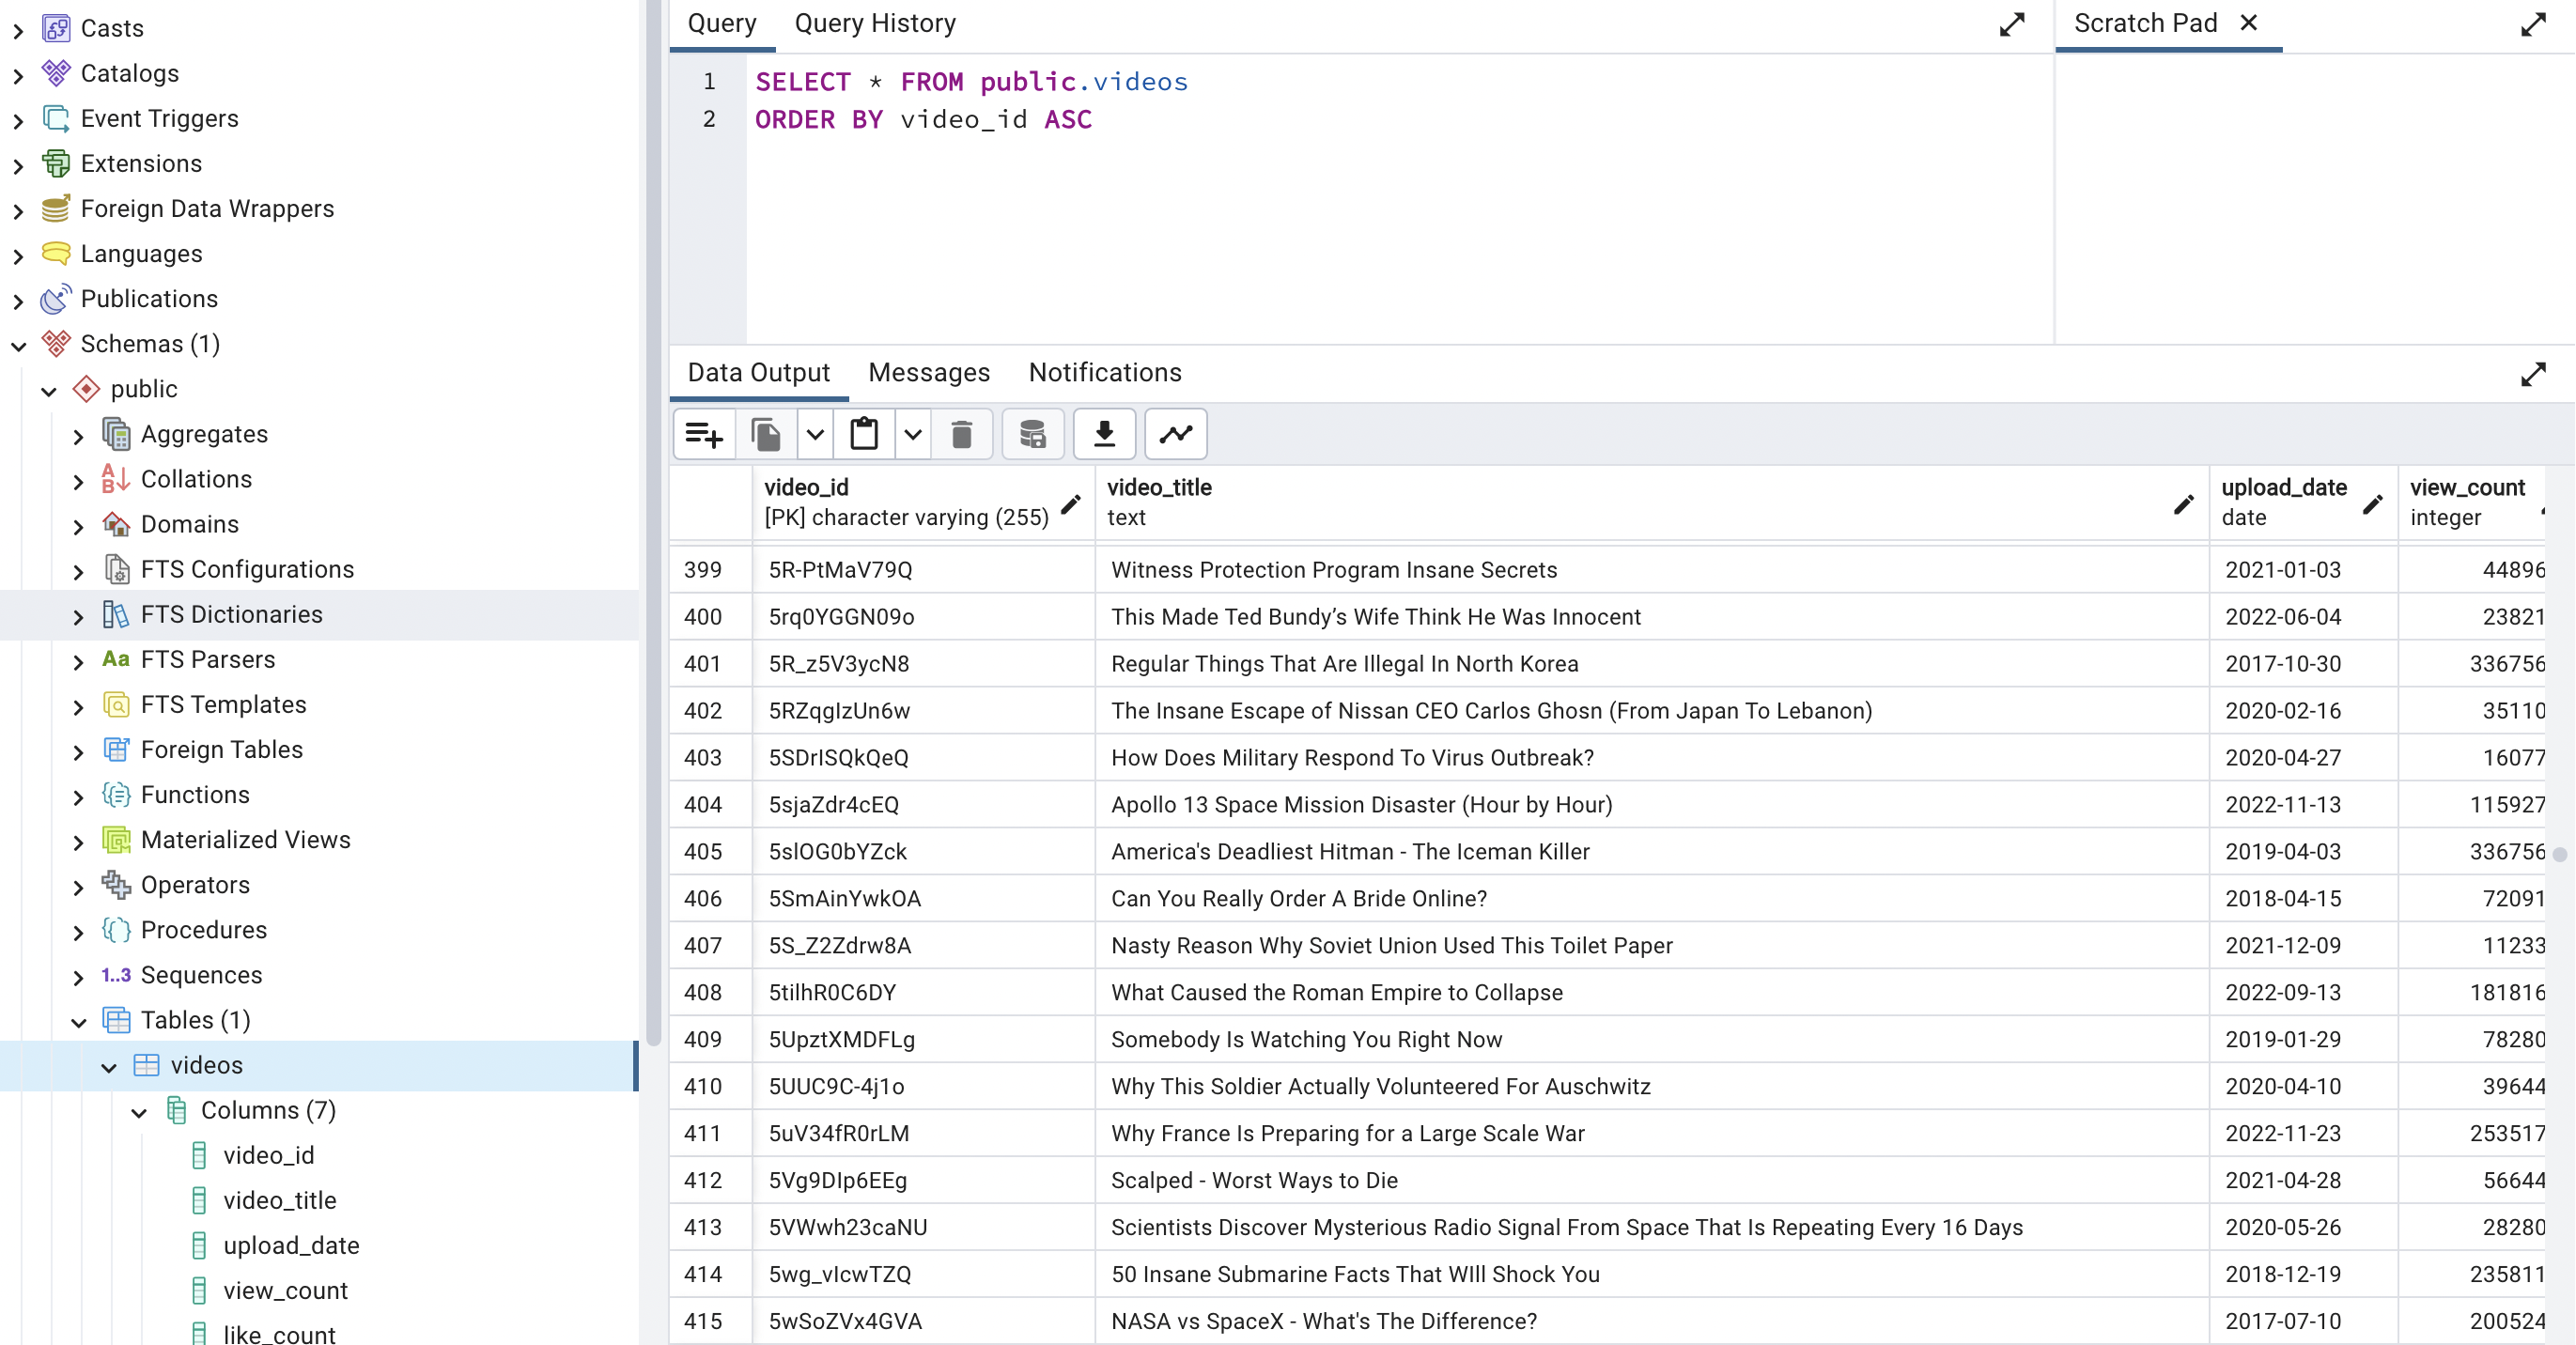

With our newly formatted data in the cloud, let's resume exploration of the current data to build a predictive model for the number of views of an Infographics Show video.

In [27]:
video_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4312 entries, 0 to 4311
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   video_id           4312 non-null   object 
 1   channelTitle       4312 non-null   object 
 2   title              4312 non-null   object 
 3   description        4312 non-null   object 
 4   tags               2788 non-null   object 
 5   publishedAt        4312 non-null   object 
 6   viewCount          4312 non-null   float64
 7   likeCount          4312 non-null   float64
 8   commentCount       4310 non-null   float64
 9   duration           4312 non-null   object 
 10  definition         4312 non-null   object 
 11  caption            4312 non-null   object 
 12  regionRestriction  919 non-null    object 
 13  duration_in_sec    4312 non-null   int64  
dtypes: float64(3), int64(1), object(10)
memory usage: 471.8+ KB


  There are 4312 entries total in the video_df dataframe, or 4312 total videos as of now. However, we see from video_df.info() that the commentCount column has missing values, as there are only 4310 non-null commentCount entries.

   When it comes to dealing with missing values, we have several approahces - deleting rows with missing values, deleting columns with missing values, or imputing missing data with values such as the mean or median of the values in a column. Since the commentCount column already has a substantial amount of data not worth dropping, we are going to impute missing values.

   However, before imputation there are a few concerns that need to be addressed. Firstly, whether we decide to impute missing values with the mean or median depends on the nature of the commentCount data. If the data is skewed, we prefer the median as it is less sensitive to outliers than the mean. If the data is approximately normal, we can use the mean. Additionally, data leakage may occur if we impute missing values in the dataset now and split the same dataset into training, validation, and testing sets. This is because data that might end up in the testing or validation sets may be used to calculate imputation values, thus giving the model an idea of what the testing data are like. Ideally, we do not want aspects of the testing set to leak into training sets.

   To combat the latter issue, we will use train test split before applying any further transformations.

First save a copy of the current dataframe with the numeric features in a new variable called video_df_numeric

In [28]:
video_df_numeric = video_df

In [29]:
video_df_numeric.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4312 entries, 0 to 4311
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   video_id           4312 non-null   object 
 1   channelTitle       4312 non-null   object 
 2   title              4312 non-null   object 
 3   description        4312 non-null   object 
 4   tags               2788 non-null   object 
 5   publishedAt        4312 non-null   object 
 6   viewCount          4312 non-null   float64
 7   likeCount          4312 non-null   float64
 8   commentCount       4310 non-null   float64
 9   duration           4312 non-null   object 
 10  definition         4312 non-null   object 
 11  caption            4312 non-null   object 
 12  regionRestriction  919 non-null    object 
 13  duration_in_sec    4312 non-null   int64  
dtypes: float64(3), int64(1), object(10)
memory usage: 471.8+ KB


In [30]:
video_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4312 entries, 0 to 4311
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   video_id           4312 non-null   object 
 1   channelTitle       4312 non-null   object 
 2   title              4312 non-null   object 
 3   description        4312 non-null   object 
 4   tags               2788 non-null   object 
 5   publishedAt        4312 non-null   object 
 6   viewCount          4312 non-null   float64
 7   likeCount          4312 non-null   float64
 8   commentCount       4310 non-null   float64
 9   duration           4312 non-null   object 
 10  definition         4312 non-null   object 
 11  caption            4312 non-null   object 
 12  regionRestriction  919 non-null    object 
 13  duration_in_sec    4312 non-null   int64  
dtypes: float64(3), int64(1), object(10)
memory usage: 471.8+ KB


In [31]:
from sklearn.model_selection import train_test_split

viewCount is our variable of interest. Hence, we drop the viewCount column from the data of potential predictors (matrix X) and have that column be the labels (vector y).

In [32]:
X = video_df.drop("viewCount" ,axis= 1)
y = video_df["viewCount"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [33]:
video_df_train = X_train.copy(deep=True)
video_lb_train = y_train.copy(deep=True)

In [34]:
video_df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3449 entries, 299 to 860
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   video_id           3449 non-null   object 
 1   channelTitle       3449 non-null   object 
 2   title              3449 non-null   object 
 3   description        3449 non-null   object 
 4   tags               2258 non-null   object 
 5   publishedAt        3449 non-null   object 
 6   likeCount          3449 non-null   float64
 7   commentCount       3447 non-null   float64
 8   duration           3449 non-null   object 
 9   definition         3449 non-null   object 
 10  caption            3449 non-null   object 
 11  regionRestriction  733 non-null    object 
 12  duration_in_sec    3449 non-null   int64  
dtypes: float64(2), int64(1), object(10)
memory usage: 377.2+ KB


When it comes to dealing with missing values, we have several approaches - deleting rows with missing values, deleting columns with missing values, or imputing missing data with values such as the mean or median of the values in a column. Since we do not want to lose commentCount data, we will proceed with imputing the missing values.
   
   Whether we decide to impute missing values with the mean or median depends on the nature of the commentCount data. If the data is skewed, we prefer the median as it is less sensitive to outliers than the mean. If the data is approximately normal, we can use the mean.
   
   To visualize the distribution of commentCount data, we can plot a histogram.

[Text(0.5, 1.0, 'Distribution of Comment Counts')]

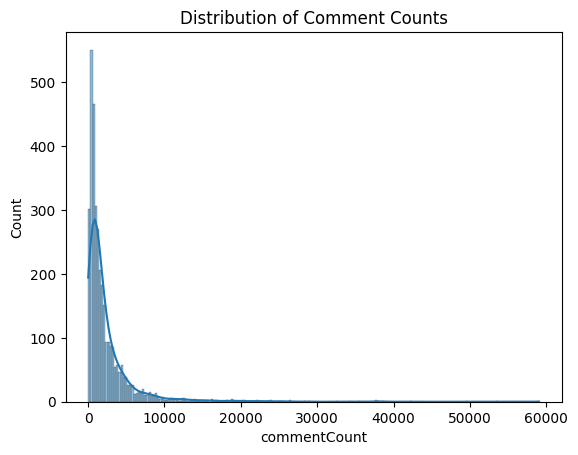

In [35]:
sns.histplot(data=video_df_train, x="commentCount", kde=True).set(title='Distribution of Comment Counts')

From the histogram above, we know that the distribution of comment counts is not only right skewed but also contains a noticeable amount of outliers. This tells us that while most of the videos have counts under 8000, there are a substantial about of videos with enormous comment counts. We can visualize this further in a box-and-whisker plot.

[Text(0.5, 1.0, 'Distribution of Comment Counts')]

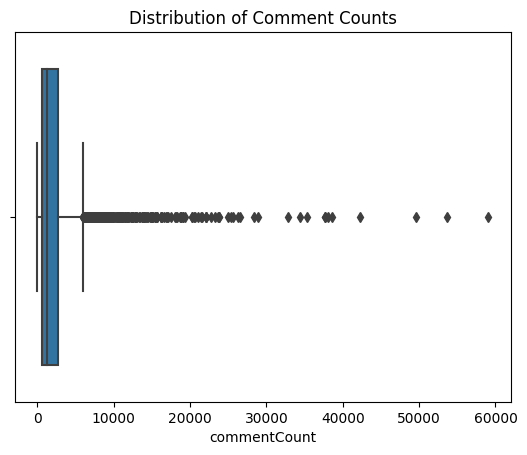

In [36]:
sns.boxplot(data=video_df_train, x="commentCount").set(title='Distribution of Comment Counts')

We can get a more solid sense of what the outliers should be through numerical computation. That is, we know from descriptive statistical theory that outliers lie 1.5 times IQR (Interquartile Range) above Q3 (75th Percentile) and below Q1 (25th Percentile).

In [37]:
comment_count_outliers = []

In [38]:
def find_outliers_iqr(data, outliers):

    """
      Detects outliers in data by using the metrics Interquartile Range (IQR), 75th Percentile (Q3), and 25th Percentile (Q1)
    """

    data = sorted(data)
    q1 = np.nanpercentile(data, 25)
    q3 = np.nanpercentile(data, 75)

    IQR = q3-q1
    lower_bound = q1-(1.5*IQR)
    upper_bound = q3+(1.5*IQR)
    print("Lower Bound: {}".format(lower_bound))
    print("Upper Bound: {}".format(upper_bound))

    for i in data:
        if (i<lower_bound or i>upper_bound):
            outliers.append(i)
    return outliers



In [39]:
sample_outliers = find_outliers_iqr(video_df_train["commentCount"], comment_count_outliers)
sample_outliers

Lower Bound: -2616.75
Upper Bound: 5953.25


[5973.0,
 6248.0,
 6292.0,
 6452.0,
 6540.0,
 6550.0,
 6556.0,
 6684.0,
 6697.0,
 6705.0,
 6860.0,
 6928.0,
 6976.0,
 7103.0,
 7256.0,
 7298.0,
 7328.0,
 7328.0,
 7466.0,
 7554.0,
 7744.0,
 7747.0,
 7777.0,
 7802.0,
 8024.0,
 8157.0,
 8169.0,
 8190.0,
 8215.0,
 8255.0,
 8278.0,
 8808.0,
 8856.0,
 8923.0,
 8929.0,
 9059.0,
 9164.0,
 11109.0,
 11311.0,
 12572.0,
 12774.0,
 12918.0,
 16154.0,
 7173.0,
 5955.0,
 5968.0,
 6003.0,
 6003.0,
 6046.0,
 6066.0,
 6087.0,
 6100.0,
 6154.0,
 6155.0,
 6168.0,
 6196.0,
 6247.0,
 6251.0,
 6264.0,
 6296.0,
 6347.0,
 6349.0,
 6395.0,
 6450.0,
 6464.0,
 6499.0,
 6527.0,
 6566.0,
 6579.0,
 6633.0,
 6635.0,
 6649.0,
 6680.0,
 6698.0,
 6712.0,
 6741.0,
 6840.0,
 6841.0,
 6842.0,
 6845.0,
 6933.0,
 6937.0,
 6990.0,
 7015.0,
 7034.0,
 7075.0,
 7079.0,
 7099.0,
 7111.0,
 7130.0,
 7140.0,
 7164.0,
 7195.0,
 7221.0,
 7262.0,
 7265.0,
 7271.0,
 7283.0,
 7292.0,
 7321.0,
 7344.0,
 7396.0,
 7400.0,
 7406.0,
 7431.0,
 7450.0,
 7519.0,
 7553.0,
 7648.0,
 7707.0,
 775

The outliers we consider are those that lie aobve 5968.5, as there are certainly no negative comment counts.

In [40]:
np.nanpercentile(video_df_train["commentCount"], 75)

2739.5

In [41]:
np.nanpercentile(video_df_train["commentCount"], 25)

597.0

In [42]:
video_df_train["commentCount"].quantile(0.90)

5310.800000000001

Since the distribution of comment counts is right skewed, we want to impute missing commentCount values with the median. The median is less affected by skewed distributions.



In [43]:
video_df_train['commentCount'] = video_df_train['commentCount'].fillna(video_df_train['commentCount'].median())
video_df_train['commentCount'].head()

299       730.0
3198      322.0
1356      347.0
3172      670.0
3482    11530.0
Name: commentCount, dtype: float64

In [44]:
video_df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3449 entries, 299 to 860
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   video_id           3449 non-null   object 
 1   channelTitle       3449 non-null   object 
 2   title              3449 non-null   object 
 3   description        3449 non-null   object 
 4   tags               2258 non-null   object 
 5   publishedAt        3449 non-null   object 
 6   likeCount          3449 non-null   float64
 7   commentCount       3449 non-null   float64
 8   duration           3449 non-null   object 
 9   definition         3449 non-null   object 
 10  caption            3449 non-null   object 
 11  regionRestriction  733 non-null    object 
 12  duration_in_sec    3449 non-null   int64  
dtypes: float64(2), int64(1), object(10)
memory usage: 377.2+ KB


Missing commentCount values have been imputed with the commentCount median.

Let's see if we can find other useful numeric features, such as the length of the video title.

In [45]:
video_df_train["titleLen"] = video_df_train["title"].apply(lambda x: len(x))
video_df_train.head()

,video_id,channelTitle,title,description,tags,publishedAt,likeCount,commentCount,duration,definition,caption,regionRestriction,duration_in_sec,titleLen
299,sKFQQ8DIKLQ,The Infographics Show,How Russians Are Avoiding the Draft #russia,,None,2023-04-07T14:00:37Z,74560.0,730.0,PT59S,hd,false,"{'blocked': ['BY', 'RU']}",59,43
3198,omFb3olCGFY,The Infographics Show,Crazy Extreme Punishments Given To Prisoners,I am proud to be working with Dollar Shave Clu...,"[prisoner, longest punishment, supermax, feder...",2019-07-26T02:15:00Z,4414.0,322.0,PT11M28S,hd,true,None,688,44
1356,Gcd2cn_6Be0,The Infographics Show,Disney Designed Gas Masks for Kids (And Other ...,When the world is at war there is nothing more...,None,2021-11-14T21:15:00Z,12271.0,347.0,PT12M24S,hd,true,None,744,72
3172,CK1lude7gjM,The Infographics Show,How A Man Frozen For Hours Is Brought Back To ...,A man found frozen after hours of being outsid...,"[frozen, freeze, ice, cold, medical, science, ...",2019-08-08T01:15:00Z,8743.0,670.0,PT8M16S,hd,true,None,496,50
3482,vS7hMricwm0,The Infographics Show,What Is Not Allowed In War?,What is actually forbidden and not allowed in ...,"[education, educational, infographics show, th...",2019-02-15T02:00:05Z,128035.0,11530.0,PT9M30S,hd,true,None,570,27


Now, let's take a look at the distributions of likeCount, viewCount, titleLen, and duration_in_sec.

[Text(0.5, 1.0, 'Distribution of Like Counts')]

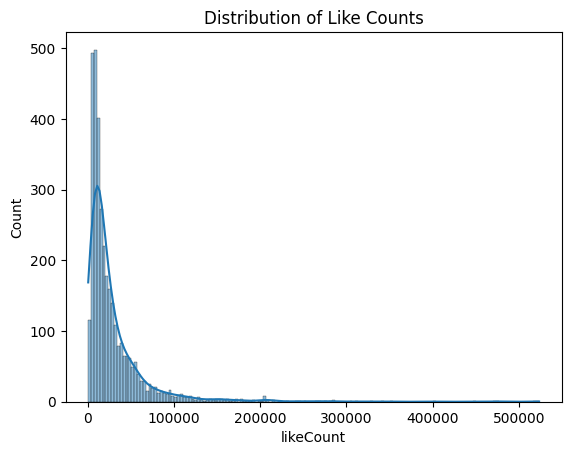

In [46]:
sns.histplot(data=video_df_train, x="likeCount", kde=True).set(title='Distribution of Like Counts')

[Text(0.5, 1.0, 'Distribution of View Counts')]

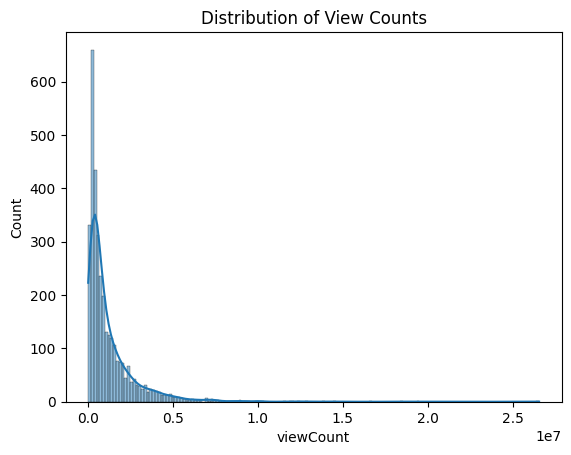

In [56]:
sns.histplot(data=video_lb_train, kde=True).set(title='Distribution of View Counts')

[Text(0.5, 1.0, 'Distribution of Title Lengths')]

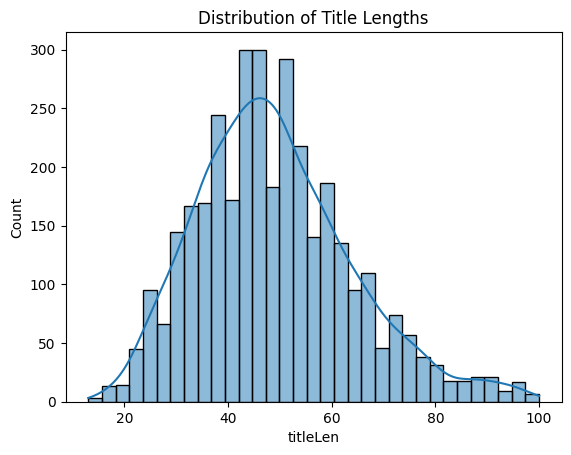

In [57]:
sns.histplot(data=video_df_train, x="titleLen", kde=True).set(title='Distribution of Title Lengths')

[Text(0.5, 1.0, 'Distribution of Title Lengths')]

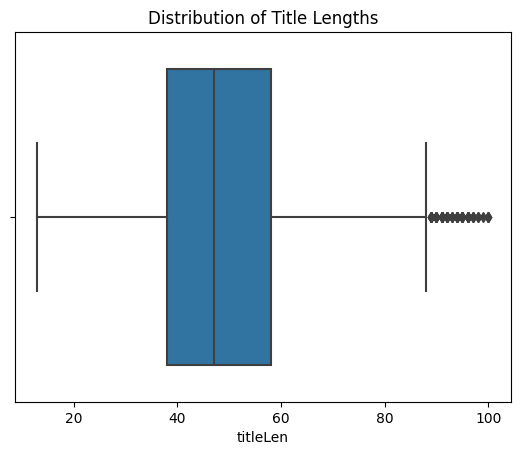

In [61]:
sns.boxplot(data=video_df_train, x="titleLen").set(title='Distribution of Title Lengths')

[Text(0.5, 1.0, 'Distribution of Duration (In Seconds)')]

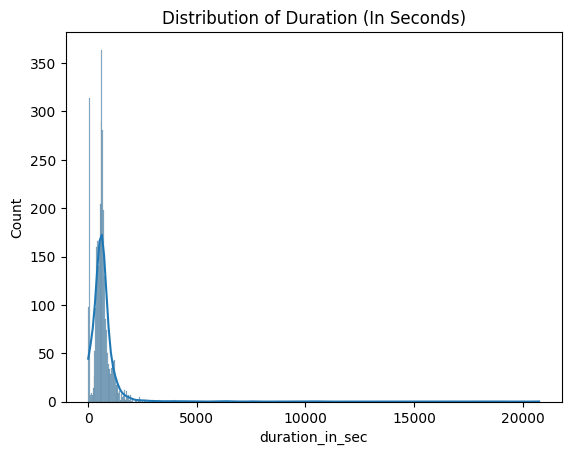

In [58]:
sns.histplot(data=video_df_train, x="duration_in_sec", kde=True).set(title='Distribution of Duration (In Seconds)')

[Text(0.5, 1.0, 'Distribution of Duration (In Seconds)')]

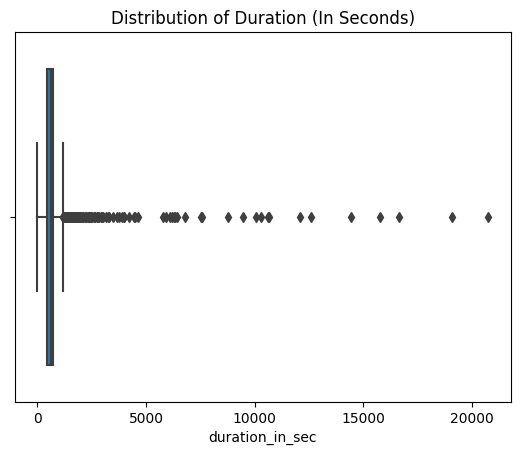

In [60]:
sns.boxplot(data=video_df_train, x="duration_in_sec").set(title='Distribution of Duration (In Seconds)')

We can see from above that the distributions of duration_in_sec and titleLen have long right tails (right-skewed distributions).

With more features containing numerical data, we can determine if there are any associations between numeric features and viewCount. We can obtain a sense of associations with the pandas corr() method. This computes a pairwise correlation between columns, excluding NA/null values. To better visualize the correlations, we can display them along with a seaborn heatmap.

In [48]:
video_df_train_copy = video_df_train.copy(deep=True)
video_df_train_copy["viewCount"] = video_lb_train

<ipython-input-49-61252d9816b3>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(video_df_train_copy.corr(), cmap="YlGnBu", annot=True)


<Axes: >

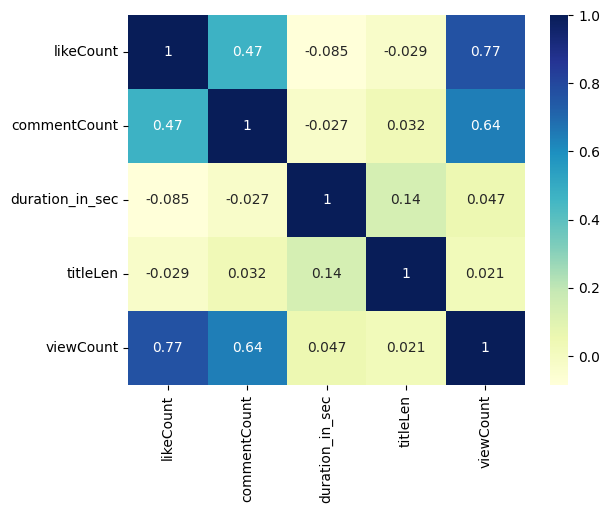

In [49]:
sns.heatmap(video_df_train_copy.corr(), cmap="YlGnBu", annot=True)

Based on the heatmap, we can see that there is a strong association between likeCount and viewCount. The association between commentCount and viewCount is also significant. Other numerical features, however, have much weaker associations with viewCount since their correlations with viewCount are close to 0. We can visualize the associations further in scatterplots.

[Text(0.5, 1.0, 'viewCount vs. likeCount')]

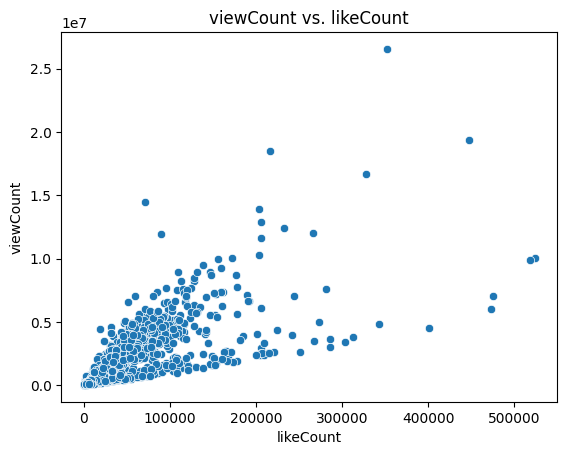

In [50]:
sns.scatterplot(data=video_df_train_copy, x="likeCount", y="viewCount").set(title='viewCount vs. likeCount')

[Text(0.5, 1.0, 'commentCount vs. viewCount')]

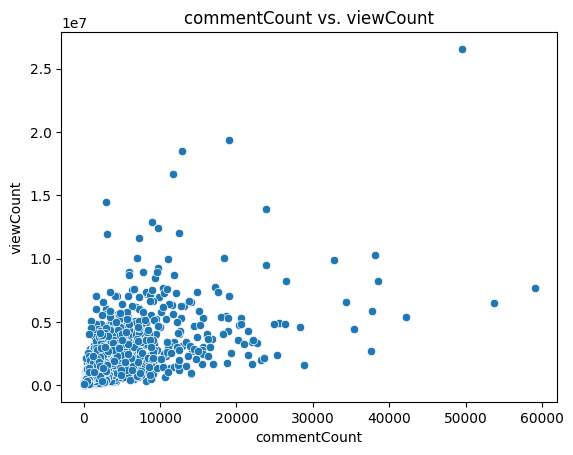

In [51]:
sns.scatterplot(data=video_df_train_copy, x="commentCount", y="viewCount").set(title='commentCount vs. viewCount')

[Text(0.5, 1.0, 'titeLen vs. viewCount')]

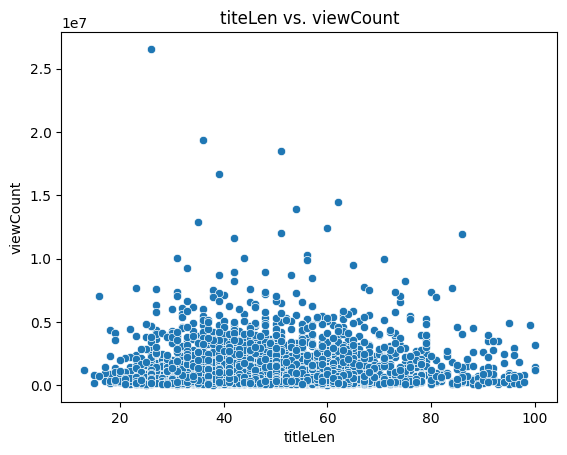

In [62]:
sns.scatterplot(data=video_df_train_copy, x="titleLen", y="viewCount").set(title='titeLen vs. viewCount')

[Text(0.5, 1.0, 'duration_in_sec vs. viewCount')]

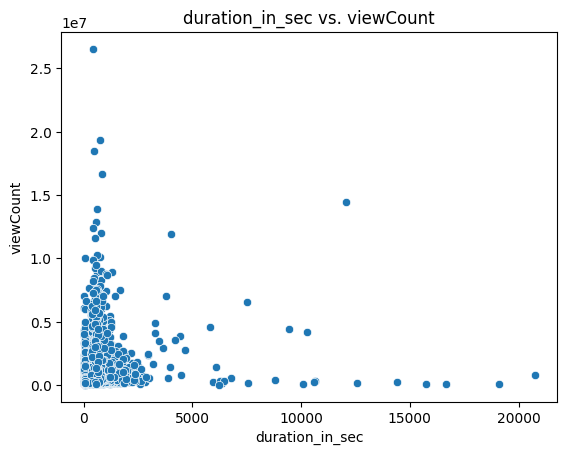

In [63]:
sns.scatterplot(data=video_df_train_copy, x="duration_in_sec", y="viewCount").set(title='duration_in_sec vs. viewCount')

It turns out that the scatterplots above caught an important detail that was not immediately clear from the heatmap - that the association between viewCount and commentCount, as well as that between viewCount and likeCount, are not clean linear relationships. The relationships between duration_in_sec and viewCount, as well as titleLen and viewCount, are even weaker.

The distribution of viewCounts is still skewed, as are those of likeCounts and commentCounts due to outliers.

We want to treat the outliers without losing information about how the data is distributed. Assuming that comment counts are computed by the YouTube platform and updated automatically upon new submissions of comments, we can decide that the outliers are unlikely to be a result of human error and should still be kept in the data. We must note though that this does not account for users inflating comment counts by posting without purpose for a specific video.

A solid method of preserving the data while mitigating the effects of extreme values is log transformation, which works especially for right skewed distributions. Log transformation makes abnormally large values small, deemphasizing outliers.

In [64]:
video_df_train_copy["log_comment"] = np.log10(video_df_train_copy["commentCount"])
video_df_train_copy["log_likes"] = np.log10(video_df_train_copy["likeCount"])
video_df_train_copy["log_views"] = np.log10(video_df_train_copy["viewCount"])
video_df_train_copy["log_duration"] = np.log10(video_df_train_copy["duration_in_sec"])
video_df_train_copy["log_titleLen"] = np.log10(video_df_train_copy["titleLen"])
video_df_train_copy.head()

,video_id,channelTitle,title,description,tags,publishedAt,likeCount,commentCount,duration,definition,caption,regionRestriction,duration_in_sec,titleLen,viewCount,log_comment,log_likes,log_views,log_duration,log_titleLen
299,sKFQQ8DIKLQ,The Infographics Show,How Russians Are Avoiding the Draft #russia,,None,2023-04-07T14:00:37Z,74560.0,730.0,PT59S,hd,false,"{'blocked': ['BY', 'RU']}",59,43,1106013.0,2.863323,4.872506,6.043760,1.770852,1.633468
3198,omFb3olCGFY,The Infographics Show,Crazy Extreme Punishments Given To Prisoners,I am proud to be working with Dollar Shave Clu...,"[prisoner, longest punishment, supermax, feder...",2019-07-26T02:15:00Z,4414.0,322.0,PT11M28S,hd,true,None,688,44,211520.0,2.507856,3.644832,5.325351,2.837588,1.643453
1356,Gcd2cn_6Be0,The Infographics Show,Disney Designed Gas Masks for Kids (And Other ...,When the world is at war there is nothing more...,None,2021-11-14T21:15:00Z,12271.0,347.0,PT12M24S,hd,true,None,744,72,672917.0,2.540329,4.088880,5.827962,2.871573,1.857332
3172,CK1lude7gjM,The Infographics Show,How A Man Frozen For Hours Is Brought Back To ...,A man found frozen after hours of being outsid...,"[frozen, freeze, ice, cold, medical, science, ...",2019-08-08T01:15:00Z,8743.0,670.0,PT8M16S,hd,true,None,496,50,365218.0,2.826075,3.941660,5.562552,2.695482,1.698970
3482,vS7hMricwm0,The Infographics Show,What Is Not Allowed In War?,What is actually forbidden and not allowed in ...,"[education, educational, infographics show, th...",2019-02-15T02:00:05Z,128035.0,11530.0,PT9M30S,hd,true,None,570,27,6289200.0,4.061829,5.107329,6.798595,2.755875,1.431364


[Text(0.5, 1.0, 'Log View Counts vs. Log Comment Counts')]

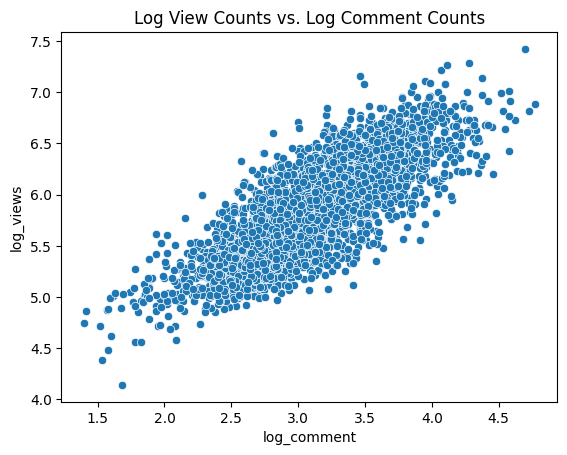

In [65]:
sns.scatterplot(data=video_df_train_copy,x="log_comment",y="log_views").set(title='Log View Counts vs. Log Comment Counts')

[Text(0.5, 1.0, 'Log View Counts vs. Log Like Counts')]

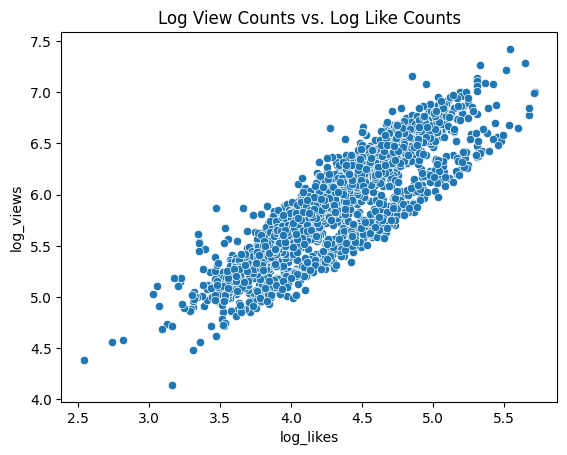

In [66]:
sns.scatterplot(data=video_df_train_copy,x="log_likes",y="log_views").set(title='Log View Counts vs. Log Like Counts')

[Text(0.5, 1.0, 'Log View Counts vs. Log Duration')]

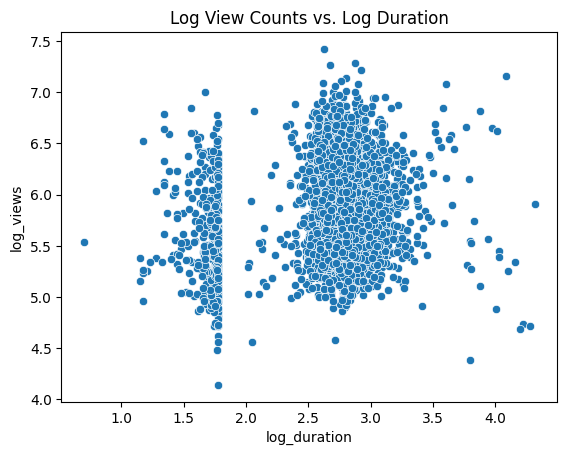

In [68]:
sns.scatterplot(data=video_df_train_copy,x="log_duration",y="log_views").set(title='Log View Counts vs. Log Duration')

[Text(0.5, 1.0, 'Log View Counts vs. Log Title Length')]

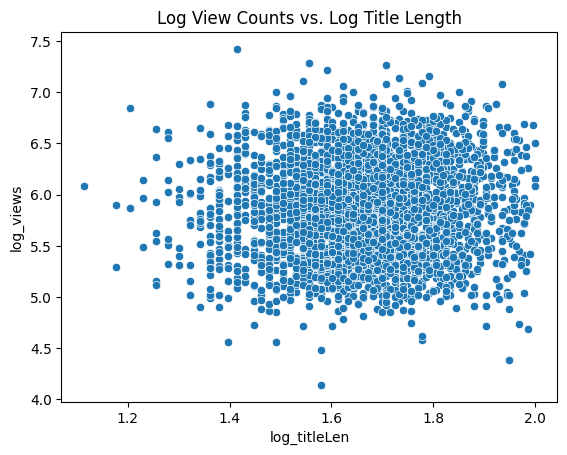

In [69]:
sns.scatterplot(data=video_df_train_copy,x="log_titleLen",y="log_views").set(title='Log View Counts vs. Log Title Length')

As we can see from the scatterplots above, we are able to get more linear relationships between logLikes and logComments with logViews. We can confirm the strong correlation with another heatmap.

<ipython-input-70-61252d9816b3>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(video_df_train_copy.corr(), cmap="YlGnBu", annot=True)


<Axes: >

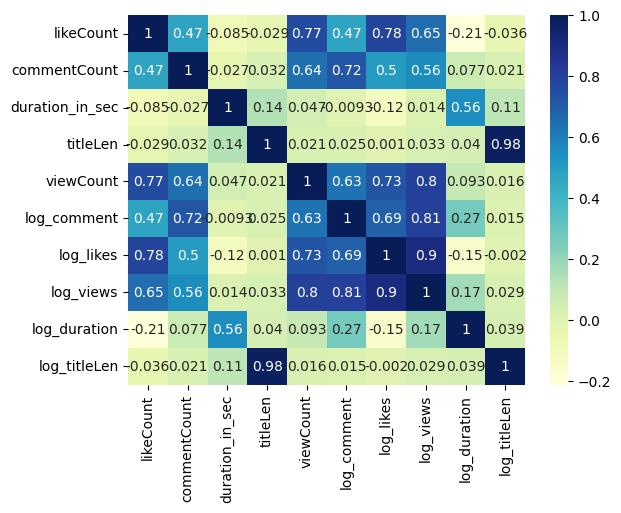

In [70]:
sns.heatmap(video_df_train_copy.corr(), cmap="YlGnBu", annot=True)

Now, we have features that have high positive correlations with log view counts, with 0.81 and 0.9 for log_comment and log_likes respectively. Other features such as log_titleLen and log_duration have low correlations with log_views. Hence, log_likes and log_comment are promising features to use as predictor variables for log_views in a linear regression model. With log_views predicted, we can retrieve the original scale of view counts by applying the appropriate inverse transformation.

In [80]:
video_df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3449 entries, 299 to 860
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   video_id           3449 non-null   object 
 1   channelTitle       3449 non-null   object 
 2   title              3449 non-null   object 
 3   description        3449 non-null   object 
 4   tags               2258 non-null   object 
 5   publishedAt        3449 non-null   object 
 6   likeCount          3449 non-null   float64
 7   commentCount       3449 non-null   float64
 8   duration           3449 non-null   object 
 9   definition         3449 non-null   object 
 10  caption            3449 non-null   object 
 11  regionRestriction  733 non-null    object 
 12  duration_in_sec    3449 non-null   int64  
 13  titleLen           3449 non-null   int64  
dtypes: float64(2), int64(2), object(10)
memory usage: 404.2+ KB


In [81]:
video_df_train_copy.describe()

,likeCount,commentCount,duration_in_sec,titleLen,viewCount,log_comment,log_likes,log_views,log_duration,log_titleLen
count,3449.000000,3449.000000,3449.000000,3449.000000,3.449000e+03,3449.000000,3449.000000,3449.000000,3449.000000,3449.000000
mean,29135.040591,2429.218324,697.067846,48.985793,1.238903e+06,3.105893,4.243611,5.842581,2.683104,1.669196
std,39934.550785,3882.190975,959.264509,15.090027,1.626667e+06,0.487364,0.421699,0.466688,0.419787,0.136722
min,349.000000,25.000000,5.000000,13.000000,1.391700e+04,1.397940,2.542825,4.143546,0.698970,1.113943
25%,8507.000000,598.000000,430.000000,38.000000,3.009330e+05,2.776701,3.929776,5.478470,2.633468,1.579784
50%,16449.000000,1243.000000,613.000000,47.000000,6.634620e+05,3.094471,4.216140,5.821816,2.787460,1.672098
75%,33737.000000,2738.000000,738.000000,58.000000,1.544358e+06,3.437433,4.528106,6.188748,2.868056,1.763428
max,523545.000000,59060.000000,20745.000000,100.000000,2.655568e+07,4.771293,5.718954,7.424157,4.316913,2.000000


At this point in the project, we have applied several preprocessing steps - imputation with median, log transformations, and additional feature engineering techniques for numerical data such as the duration of a video and length of a video title.

Based on the heatmap, the features we will consider come from likeCount, commentCount, duration, and title. That is, the log transformations of likeCount, commentCount, duration, and title.

In [82]:
X_train_temp = X_train.copy(deep=True)
X_train_temp = X_train_temp[["likeCount", "commentCount", "duration", "title"]]
X_train_temp.head(5)

,likeCount,commentCount,duration,title
299,74560.0,730.0,PT59S,How Russians Are Avoiding the Draft #russia
3198,4414.0,322.0,PT11M28S,Crazy Extreme Punishments Given To Prisoners
1356,12271.0,347.0,PT12M24S,Disney Designed Gas Masks for Kids (And Other ...
3172,8743.0,670.0,PT8M16S,How A Man Frozen For Hours Is Brought Back To ...
3482,128035.0,11530.0,PT9M30S,What Is Not Allowed In War?


In [83]:
y_train_temp = y_train.copy(deep=True)

# Modeling
We will use linear regression to predict the number of views for a video that has certain numerical features, such as like count and comment count.

Since we have already explored the appropriate transformations and feature engineering techniques to make a linear regression model feasible for this dataset, we can concisely express all of the transformations into a machine learning pipeline. Our original training data X_train, unaffected by its copy video_df_train, will go through the same series of transformations prior to model training.

Below are the necessary imports for the various transformers we will use in our pipeline.

In [84]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline,make_pipeline

from numpy import mean
from numpy import std
from numpy import absolute
from numpy import sqrt


Finding the best linear regression model requires to meet 2 objectives - finding the optimal number of features to use, as well as the best features to use.

To accomplish the first objective, we can feed our pipeline into a GridSearchCV object. The GridSearchCV object will perform cross validation tests in the background to rank the different numbers of features (k) with their negative mean squared errors. Higher negative mean squared errors are better since they amount to lower negative mean squared errors.

Once we obtain the best value of k, or the number of features we need, we can select the best k features based on their correlation with the target variable (log of viewCount).

With our objectives clear, we can proceed with the pipeline.

In [85]:
X_train_temp["duration"] = X_train_temp["duration"].apply(lambda x: duration_to_sec(x))
X_train_temp.head(5)

,likeCount,commentCount,duration,title
299,74560.0,730.0,59,How Russians Are Avoiding the Draft #russia
3198,4414.0,322.0,688,Crazy Extreme Punishments Given To Prisoners
1356,12271.0,347.0,744,Disney Designed Gas Masks for Kids (And Other ...
3172,8743.0,670.0,496,How A Man Frozen For Hours Is Brought Back To ...
3482,128035.0,11530.0,570,What Is Not Allowed In War?


In [86]:
X_train_temp["title"] = X_train_temp["title"].apply(lambda x: len(x))
X_train_temp.head(5)

,likeCount,commentCount,duration,title
299,74560.0,730.0,59,43
3198,4414.0,322.0,688,44
1356,12271.0,347.0,744,72
3172,8743.0,670.0,496,50
3482,128035.0,11530.0,570,27


In [87]:
transformer_y_train = FunctionTransformer(np.log10)
y_train_temp = transformer_y_train.transform(y_train_temp)

In [88]:

trf1 = ColumnTransformer([('impute_comment',SimpleImputer(strategy='median'),[1])],remainder='passthrough')
trf2 = ColumnTransformer([('log_transform',FunctionTransformer(np.log10),[3,2,1,0])],remainder='passthrough')
trf3 = SelectKBest(score_func=f_regression)
trf4 = LinearRegression()

pipe = Pipeline([
    ('trf1', trf1),
    ('trf2', trf2),
    ('sel', trf3),
    ('trf4', trf4)
])

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

grid = dict()
grid['sel__k'] = [i for i in range(1, 5)]
# define the grid search
search = GridSearchCV(pipe, grid, scoring='neg_mean_squared_error', n_jobs=-1, cv=cv)
# perform the search
results = search.fit(X_train_temp, y_train_temp)
# summarize best
print('Best MAE: %.3f' % results.best_score_)
print('Best Config: %s' % results.best_params_)
# summarize all
means = results.cv_results_['mean_test_score']
params = results.cv_results_['params']
for mean, param in zip(means, params):
    print(">%.3f with: %r" % (mean, param))


Best MAE: -0.019
Best Config: {'sel__k': 4}
>-0.043 with: {'sel__k': 1}
>-0.028 with: {'sel__k': 2}
>-0.019 with: {'sel__k': 3}
>-0.019 with: {'sel__k': 4}


As we can see from the cross validation above, the optimal number of features to use (best value of k) is 4 since it has the greatest MAE value.

Now that we know the optimal value of k, we can select the k best features below.

In [90]:
X_train_features = X_train_temp.copy(deep=True)
X_train_features['commentCount'] = X_train_features['commentCount'].fillna(X_train_features['commentCount'].median())
X_train_features['commentCount'] = X_train_features['commentCount'].apply(lambda x: np.log10(x))
X_train_features['likeCount'] = X_train_features['likeCount'].apply(lambda x: np.log10(x))
X_train_features['duration'] = X_train_features['duration'].apply(lambda x: np.log10(x))
X_train_features['title'] = X_train_features['title'].apply(lambda x: np.log10(x))

In [95]:
def select_features(X_train, y_train, k):
  """
    Selects best k features from a dataset.
  """
  fs = SelectKBest(score_func=f_regression, k=k)
  fs.fit(X_train, y_train)
  X_train_fs = fs.transform(X_train)
  return X_train_fs, fs

#feature selection
X_train_fs, fs = select_features(X_train_features, y_train_temp, 4)
# what are scores for the features
for i in range(len(fs.scores_)):
  print('Feature %d: %f' % (i, fs.scores_[i]))

Feature 0: 14164.611174
Feature 1: 6355.012569
Feature 2: 99.598011
Feature 3: 2.947053


In [96]:
X_train_features.head(5)

,likeCount,commentCount,duration,title
299,4.872506,2.863323,1.770852,1.633468
3198,3.644832,2.507856,2.837588,1.643453
1356,4.088880,2.540329,2.871573,1.857332
3172,3.941660,2.826075,2.695482,1.698970
3482,5.107329,4.061829,2.755875,1.431364


The 4 optimal features to use are the logs of likes, comments, duration, and length of title. Based on the scores for each of the features, number of likes and number of comments have the greatest positive correlation with number of views.

In [114]:
def do_cross_validation(X_data, y_data):
    #define cross-validation method to use
    cv = KFold(n_splits=10, random_state=1, shuffle=True)

    #build multiple linear regression model
    model = LinearRegression()

    #use k-fold CV to evaluate model
    scores = cross_val_score(model, X_data, y_data, scoring='neg_mean_absolute_error',
                             cv=cv, n_jobs=-1)

    #view mean absolute error
    #return mean(absolute(scores))
    return np.mean(np.absolute(scores))

In [115]:
do_cross_validation(X_train_features, y_train_temp)

0.10574489125351853

We wil now make predictions for the test set.

In [138]:
X_test_transformed.head(5)

,likeCount,commentCount,duration_in_sec,title
3790,35575.0,4126.0,615,Boy Scout Tried To Build a Nuclear Reactor in ...
3269,18424.0,1043.0,632,Unbelievable But Real Psych Ward Stories
2274,83912.0,6909.0,643,What if The Real Annabelle Escaped?
912,14053.0,732.0,1916,How They Finally Caught The Nazi Butcher
2346,22547.0,3084.0,689,How Could a Roman Legion Defeat a Tank?


In [162]:
X_test_transformed = X_test[["likeCount", "commentCount", "duration_in_sec", "title"]].copy(deep=True)

In [163]:
X_test_transformed["commentCount"] = X_test_transformed['commentCount'].fillna(X_test_transformed['commentCount'].median())
X_test_transformed['commentCount'] = X_test_transformed['commentCount'].apply(lambda x: np.log10(x))
X_test_transformed['likeCount'] = X_test_transformed['likeCount'].apply(lambda x: np.log10(x))
X_test_transformed['duration'] = X_test_transformed['duration_in_sec'].apply(lambda x: np.log10(x))
X_test_transformed['title'] = X_test_transformed['title'].apply(lambda x: len(x))
X_test_transformed['title'] = X_test_transformed['title'].apply(lambda x: np.log10(x))

Making sure we have the same ordering of features for both training and testing sets, we look at the first several rows of each.

In [164]:
X_test_transformed.drop(['duration_in_sec'], inplace=True, axis=1)
X_test_transformed = X_test_transformed[["likeCount", "commentCount", "duration", "title"]]
X_test_transformed.head(5)

,likeCount,commentCount,duration,title
3790,4.551145,3.615529,2.788875,1.763428
3269,4.265384,3.018284,2.800717,1.602060
2274,4.923824,3.839415,2.808211,1.544068
912,4.147769,2.864511,3.282396,1.602060
2346,4.353089,3.489114,2.838219,1.591065


In [165]:
X_train_features.head(5)

,likeCount,commentCount,duration,title
299,4.872506,2.863323,1.770852,1.633468
3198,3.644832,2.507856,2.837588,1.643453
1356,4.088880,2.540329,2.871573,1.857332
3172,3.941660,2.826075,2.695482,1.698970
3482,5.107329,4.061829,2.755875,1.431364


In [166]:
y_test_transformed = y_test.apply(lambda x: np.log10(x))

In [167]:
model = LinearRegression()
model.fit(X_train_features, y_train_temp)

LinearRegression()

In [168]:
log_predictions = model.predict(X_test_transformed)
#Mean Squared Error of Log Predictions
sum((log_predictions - y_test_transformed) ** 2) / len(log_predictions)

0.017752288599788894

In [171]:
y_test_transformed

3790    6.293582
3269    6.092739
2274    6.472412
912     6.027133
2346    5.884461
          ...   
3515    6.148265
1747    5.700866
1718    5.539757
358     5.507267
3224    5.185576
Name: viewCount, Length: 863, dtype: float64

In [172]:
log_predictions

array([6.24190214, 5.87380884, 6.60554903, 5.87093868, 6.0449656 ,
       5.44370975, 5.71678609, 5.59644368, 5.75611952, 6.79789339,
       6.43031157, 5.96710313, 5.46962693, 5.501558  , 5.42687959,
       5.87488256, 5.19567182, 6.06982076, 6.36173782, 5.09322254,
       5.89724047, 5.88724159, 6.60359851, 6.22223984, 6.39705288,
       6.53681452, 6.28757633, 5.18136009, 5.57348716, 6.14216038,
       5.77137133, 6.02228469, 5.69571312, 5.72988214, 5.55962587,
       5.82457796, 6.46385855, 5.46487003, 5.9130824 , 6.06110025,
       5.12555621, 4.75300376, 6.43433517, 5.14992062, 5.97780947,
       5.5675417 , 5.88233072, 6.05982909, 5.99769571, 6.88815686,
       6.02594857, 5.36868109, 5.54739452, 6.12239583, 5.73409389,
       5.4407351 , 5.24555877, 5.95791819, 6.11083002, 7.06114224,
       5.27700129, 6.21531479, 6.33262417, 4.8956171 , 4.74805051,
       5.94020233, 6.14055809, 6.20737137, 5.88330894, 5.13775616,
       5.7482357 , 5.26965967, 6.16254793, 5.37442386, 6.23137

Since our predictions are still on a log scale, we can apply an inverse transformation by raising 10 to the power of our log predictions. The result is an array of view count predictions in the original count scale.

In [169]:
predictions = 10 ** log_predictions
predictions

array([1.74542880e+06, 7.47840264e+05, 4.03226468e+06, 7.42914240e+05,
       1.10908696e+06, 2.77785613e+05, 5.20938057e+05, 3.94860486e+05,
       5.70321203e+05, 6.27904197e+06, 2.69346643e+06, 9.27049938e+05,
       2.94867513e+05, 3.17364250e+05, 2.67226543e+05, 7.49691447e+05,
       1.56917658e+05, 1.17441276e+06, 2.30005288e+06, 1.23943152e+05,
       7.89297026e+05, 7.71332434e+05, 4.01419543e+06, 1.66816819e+06,
       2.49489847e+06, 3.44202895e+06, 1.93899339e+06, 1.51830873e+05,
       3.74530475e+05, 1.38726803e+06, 5.90705928e+05, 1.05265168e+06,
       4.96264399e+05, 5.36886079e+05, 3.62765410e+05, 6.67694747e+05,
       2.90976922e+06, 2.91655404e+05, 8.18620091e+05, 1.15106607e+06,
       1.33523039e+05, 5.66244190e+04, 2.71853651e+06, 1.41227938e+05,
       9.50187834e+05, 3.69438115e+05, 7.62659554e+05, 1.14770188e+06,
       9.94708216e+05, 7.72959717e+06, 1.06156984e+06, 2.33712042e+05,
       3.52691118e+05, 1.32554915e+06, 5.42118084e+05, 2.75889454e+05,
      

Comparing the view count predictions with the test set view counts, we see instances where our linear regression model both underestimated and overestimated the predictions. However, the model was able to provide large approximations of view counts for greater values of actual view counts and small approximations of view counts for smaller values of actual view counts, as hinted by the strong correlations between view counts, like counts, and comment counts.

In [181]:
print("Actual: {}, Predicted: {}".format(y_test.iloc[0], predictions[0]))

Actual: 1965994.0, Predicted: 1745428.7988803429


In [184]:
print("Actual: {}, Predicted: {}".format(y_test.iloc[3], predictions[3]))

Actual: 1064469.0, Predicted: 742914.2398739661


In [186]:
print("Actual: {}, Predicted: {}".format(y_test.iloc[5], predictions[5]))

Actual: 174251.0, Predicted: 277785.612705819


In [187]:
print("Actual: {}, Predicted: {}".format(y_test.iloc[6], predictions[6]))

Actual: 634586.0, Predicted: 520938.0567640271


In [188]:
print("Actual: {}, Predicted: {}".format(y_test.iloc[10], predictions[10]))

Actual: 3043009.0, Predicted: 2693466.4323695004


In [189]:
print("Actual: {}, Predicted: {}".format(y_test.iloc[11], predictions[11]))

Actual: 845848.0, Predicted: 927049.9375304267


Based off of the results, we can conclude that large numbers of likes and comments are associated with large number of views. In other words, we can expect a large number of views based off of a large number of likes and comments.

Despite the strength of correlated features in constructing our linear model, the model does not consider aspects like sentiment of comments or video content. Even though view counts can be approximated from number of likes and comments, the quality of the video content - whether it is enlighting, depressing, or viral - is also a huge factor in the visibility of a You Tube video. Hence, more complex feature engineering techniques and possibly more data are needed to account for video details that are not immediately seen from fresh YouTube API data.